In [1]:
import os
import re
import random
import pandas as pd
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [2]:
def extract_info_from_filename(file_name):
    # 定义正则表达式模式，匹配带故障的文件名
    pattern_faulty = re.compile(r'(\d+)k_(\w+)_([\w@]+)_(\d+)_(\d+)\.mat')

    # 定义正则表达式模式，匹配正常文件名
    pattern_normal = re.compile(r'normal_(\d+)_(\d+)\.mat')

    # 尝试匹配故障文件名
    match_faulty = pattern_faulty.match(file_name)
    if match_faulty:
        # 提取匹配的信息
        sample_frequence = int(match_faulty.group(1))  # 转速
        drive_end = match_faulty.group(2)   # 驱动端
        fault_info = match_faulty.group(3)  # 故障信息
        severity = int(match_faulty.group(4))  # 严重程度
        trial_number = int(match_faulty.group(5))  # 试验编号

        return {
            'Type': 'Faulty',
            'Sample Frequence': sample_frequence,
            'Drive End': drive_end,
            'Fault Info': fault_info,
            'Load': severity,
            'Trial Number': trial_number
        }
    else:
        # 尝试匹配正常文件名
        match_normal = pattern_normal.match(file_name)
        if match_normal:
            # 提取匹配的信息
            severity = int(match_normal.group(1))  # 严重程度
            trial_number = int(match_normal.group(2))  # 试验编号

            return {
                'Type': 'Normal',
                'Load': severity,
                'Trial Number': trial_number
            }
        else:
            print(f"Filename '{file_name}' does not match any pattern.")
            return None

# # 测试文件名
# file_names = ['12k_Drive_End_IR028_3_3004.mat', '12k_Drive_End_OR007@6_0_130.mat', '48k_Drive_End_B007_3_125.mat', 'normal_0_97.mat']

# # 提取信息并打印
# for file_name in file_names:
#     info = extract_info_from_filename(file_name)
#     if info:
#         print(f"\nInformation extracted from '{file_name}':")
#         for key, value in info.items():
#             print(f"{key}: {value}")


In [3]:
def read_mat_files(folder_path):
    data = []
    labels = []
    speed= []

    for filename in os.listdir(folder_path):
        if filename.endswith(".mat"):
            infomationOfFilename=extract_info_from_filename(filename)
            print(infomationOfFilename)
            file_path = os.path.join(folder_path, filename)
            mat_data = loadmat(file_path)
#             print(mat_data)
            
            # 这里假设MAT文件中有一个数组变量名为'data'，你可以根据实际情况修改
            mat_variable_data = mat_data.get('X'+str(infomationOfFilename["Trial Number"])+"_DE_time", None)
            if infomationOfFilename["Trial Number"]>=100:
                mat_variable_data = mat_data.get('X'+str(infomationOfFilename["Trial Number"])+"_DE_time", None)
                mat_speed = mat_data.get('X'+str(infomationOfFilename["Trial Number"])+"RPM", None)
            else:
                mat_variable_data = mat_data.get('X'+"0"+str(infomationOfFilename["Trial Number"])+"_DE_time", None)
                mat_speed = mat_data.get('X'+"0"+str(infomationOfFilename["Trial Number"])+"RPM", None)
            if mat_variable_data is not None:
                # 将数组数据转换为一维数组或一维列表，具体取决于你的需求
                flattened_data = mat_variable_data.flatten()
                data.append(flattened_data)
                labels.append(filename)
                if mat_speed is not None:
                    speed.append(mat_speed[0][0])
                else:
                    speed.append(0)
                


    df = pd.DataFrame({'data': data, 'label': labels,"speed":speed})
    return df

In [4]:
# 指定包含MAT文件的文件夹路径
folder_path = 'H:\project\data\cwru\CaseWesternReserveUniversityData'

# 读取MAT文件并创建DataFrame
df = read_mat_files(folder_path)

# 打印DataFrame的前几行
print(df.head())
df.to_csv("cwru_DE_data.csv")


{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Drive_End', 'Fault Info': 'B007', 'Load': 0, 'Trial Number': 118}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Drive_End', 'Fault Info': 'B007', 'Load': 1, 'Trial Number': 119}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Drive_End', 'Fault Info': 'B007', 'Load': 2, 'Trial Number': 120}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Drive_End', 'Fault Info': 'B007', 'Load': 3, 'Trial Number': 121}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Drive_End', 'Fault Info': 'B014', 'Load': 0, 'Trial Number': 185}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Drive_End', 'Fault Info': 'B014', 'Load': 1, 'Trial Number': 186}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Drive_End', 'Fault Info': 'B014', 'Load': 2, 'Trial Number': 187}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Drive_End', 'Fault Info': 'B014', 'Load': 3, 'Trial Number': 188}
{'Type': 'Faulty

{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Fan_End', 'Fault Info': 'B021', 'Load': 3, 'Trial Number': 293}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Fan_End', 'Fault Info': 'IR007', 'Load': 0, 'Trial Number': 278}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Fan_End', 'Fault Info': 'IR007', 'Load': 1, 'Trial Number': 279}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Fan_End', 'Fault Info': 'IR007', 'Load': 2, 'Trial Number': 280}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Fan_End', 'Fault Info': 'IR007', 'Load': 3, 'Trial Number': 281}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Fan_End', 'Fault Info': 'IR014', 'Load': 0, 'Trial Number': 274}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Fan_End', 'Fault Info': 'IR014', 'Load': 1, 'Trial Number': 276}
{'Type': 'Faulty', 'Sample Frequence': 12, 'Drive End': 'Fan_End', 'Fault Info': 'IR014', 'Load': 2, 'Trial Number': 276}
{'Type': 'Faulty', 'Sampl

{'Type': 'Faulty', 'Sample Frequence': 48, 'Drive End': 'Drive_End', 'Fault Info': 'OR007@6', 'Load': 3, 'Trial Number': 138}
{'Type': 'Faulty', 'Sample Frequence': 48, 'Drive End': 'Drive_End', 'Fault Info': 'OR014@6', 'Load': 0, 'Trial Number': 201}
{'Type': 'Faulty', 'Sample Frequence': 48, 'Drive End': 'Drive_End', 'Fault Info': 'OR014@6', 'Load': 1, 'Trial Number': 202}
{'Type': 'Faulty', 'Sample Frequence': 48, 'Drive End': 'Drive_End', 'Fault Info': 'OR014@6', 'Load': 2, 'Trial Number': 203}
{'Type': 'Faulty', 'Sample Frequence': 48, 'Drive End': 'Drive_End', 'Fault Info': 'OR014@6', 'Load': 3, 'Trial Number': 204}
{'Type': 'Faulty', 'Sample Frequence': 48, 'Drive End': 'Drive_End', 'Fault Info': 'OR021@12', 'Load': 0, 'Trial Number': 262}
{'Type': 'Faulty', 'Sample Frequence': 48, 'Drive End': 'Drive_End', 'Fault Info': 'OR021@12', 'Load': 1, 'Trial Number': 263}
{'Type': 'Faulty', 'Sample Frequence': 48, 'Drive End': 'Drive_End', 'Fault Info': 'OR021@12', 'Load': 2, 'Trial Num

In [5]:
tem_data_path = folder_path+r"\normal_1_98.mat"
mat_data = loadmat(tem_data_path)
mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri Jan 28 10:52:35 2000',
 '__version__': '1.0',
 '__globals__': [],
 'X098_DE_time': array([[ 0.046104  ],
        [-0.03713354],
        [-0.089496  ],
        ...,
        [-0.09909231],
        [-0.10827138],
        [-0.07092923]]),
 'X098_FE_time': array([[ 0.02321636],
        [ 0.08115455],
        [ 0.09533091],
        ...,
        [-0.00760182],
        [ 0.04026909],
        [ 0.06102   ]])}

In [6]:
cell_data = df.iloc[10, 0]
cell_data

array([ 0.25404854, -0.05003002, -0.01315725, ..., -0.13790743,
        0.08040539,  0.20856671])

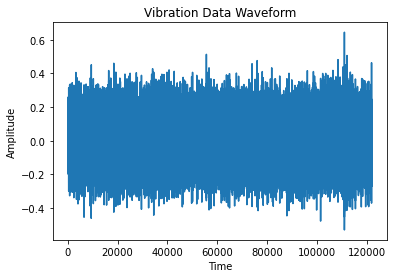

In [7]:
import matplotlib.pyplot as plt

# 绘制波形
plt.plot(cell_data)
plt.title('Vibration Data Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [68]:
def validate_OR(input_str):
    #识别str是否是out ring的故障类型
    pattern = re.compile(r'^[A-Z]{2}\d{3}@\d{1,2}$')
    return bool(pattern.match(input_str))

all_labels = ['B007','B014','B021','IR007','IR014','IR021','OR007@6','OR014@6','OR021@6']
#随机生成训练集和测试集lables，并打印区别
num_labels_to_select = random.randint(3, 7)
trainlabels = random.sample(all_labels, num_labels_to_select)
testlabels = random.sample(all_labels, num_labels_to_select)
trainlabels.append("normal")
testlabels.append("normal")
all_labels.append("normal")
print(list(set(trainlabels).symmetric_difference(set(testlabels))))#应该先求交后求差

def build_dataset(df,all_labels,trainlabels,testlabels):
    # 读取MAT文件并创建DataFrame
    #设置参数
    load = 0
    filepath = "train.csv"
    
#     all_labels_idex = [0,1,2,3,4,5,6,7,8,9]
    train_ratio = 0.7
    #初始化中间变量
    train_data = []
    train_label = []
    test_data = []
    test_label = []
    
    #构建测试集和训练集，使用采样频率为12k的drive_end数据
    for i in range(df.shape[0]):
        file_info = extract_info_from_filename(df.loc[i]["label"])
        if file_info["Type"]!="Normal":
            if file_info['Sample Frequence']==12 and file_info['Drive End'] =="Drive_End":               
                if file_info['Load']==load:                  
                    if validate_OR(file_info['Fault Info']) :
                        #使用OR的6方向
                        if file_info['Fault Info'].split('@')[1]=="3" or file_info['Fault Info'].split('@')[1]=="12":
                            continue                    
#                     print(file_info)
#                     if file_info['Fault Info'] in trainlabels:
                    train_data.append(df.loc[i]["data"][:int(len(df.loc[i]["data"])*train_ratio)])
                    train_label.append(all_labels.index(file_info["Fault Info"]))#使用故障类型在all_labels中的index作为y值，下同                    
#                     if file_info['Fault Info'] in testlabels:
                    test_data.append(df.loc[i]["data"][int(len(df.loc[i]["data"])*train_ratio)+1:])
                    test_label.append(all_labels.index(file_info["Fault Info"]))
        #将normal数据加入训练集,normal的代号为9             
        if file_info["Type"]=="Normal" and file_info["Load"]==load:
            train_data.append(df.loc[i]["data"][:int(len(df.loc[i]["data"])*train_ratio)])
            train_label.append(9)
            test_data.append(df.loc[i]["data"][int(len(df.loc[i]["data"])*train_ratio)+1:])
            test_label.append(9)
#     输出csv
    train = pd.DataFrame({"data":train_data,"label":train_label})
    train.to_csv(filepath) 
    test = pd.DataFrame({"data":test_data,"label":test_label})
    test.to_csv("test.csv") 
    #返回dataframe类型的训练集和测试集数据
    return train,test

train,test = build_dataset(df,all_labels,trainlabels,testlabels)


['OR021@6', 'OR007@6', 'B021', 'IR014']


In [73]:
print(len(test.iloc[0,0]))
print(len(train.iloc[0,0]))

36771
85799


In [74]:
test

,data,label
0,"[-0.21880011976047903, -0.05327872255489022, 0...",0
1,"[-0.09047636726546907, -0.0779688622754491, -0...",1
2,"[0.017705429141716567, 0.16389704590818363, 0....",2
3,"[0.1531763273453094, 0.12068930139720559, -0.1...",3
4,"[-0.017705429141716567, 0.1052579640718563, 0....",4
5,"[-0.6026343313373254, -0.2663936127744511, 0.5...",5
6,"[0.21806916167664672, 0.312687624750499, -0.15...",6
7,"[0.012666826347305388, -0.20506455089820358, 0...",7
8,"[0.06741057884231537, -0.030456586826347304, 0...",8
9,"[-0.05736923076923077, -0.061750153846153844, ...",9


In [77]:
def segment_time_series(time_series):
    #设置参数
    segment_length = 1024
    step = 10
#     初始化中间变量
    segments = []
    for i in range(0, len(time_series), step):
        segment = time_series[i:i + segment_length]
        if len(segment) == segment_length:
            segments.append(segment)
    return segments

def create_testdataset(train,test,all_labels,train_labels,test_labels,phase = "train"):
    #初始化中间变量
    data = []
    labels = []
    testdata = []
    testlabels = []
    for i in range(train.shape[0]): 
        if phase =="train" and all_labels[train.iloc[i,1]] in train_labels:
            segments = segment_time_series(train.iloc[i,0])
            data.extend(segments)
            labels.extend([train.iloc[i,1]]*len(segments))            
            segments = segment_time_series(test.iloc[i,0])
            testdata.extend(segments)
            testlabels.extend([test.iloc[i,1]]*len(segments))
        if phase =="test" and all_labels[test.iloc[i,1]] in test_labels:#加入测试阶段测试集数据，包括normal
            segments = segment_time_series(test.iloc[i,0])
            testdata.extend(segments)
            testlabels.extend([test.iloc[i,1]]*len(segments))
    if phase =="train":    
        np.save("train_train"+"_x.npy", np.array(data))
        np.save("train_train"+"_y.npy", np.array(labels))
        np.save("train_test"+"_x.npy", np.array(testdata))
        np.save("train_test"+"_y.npy", np.array(testlabels))
    if phase =="test":    
        np.save("test_test"+"_x.npy", np.array(testdata))
        np.save("test_test"+"_y.npy", np.array(testlabels))
   
         
create_testdataset(train,test,all_labels,trainlabels,testlabels,phase = "train") 
create_testdataset(train,test,all_labels,trainlabels,testlabels,phase = "test") 
    

In [12]:
# 1. 加载数据集
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train = np.load('traindataset.npy',allow_pickle=True)
test = np.load('testdataset.npy',allow_pickle=True) 

# 假设有一个包含开集的训练集
print(train)
train_dataset = train
test_dataset = test

# 2. 将训练集划分为训练集和开集
# train_data, open_set_data, _, _ = train_test_split(train_dataset, train_size=0.8, random_state=42, stratify=train_dataset.targets)

# 3. 构建模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 类别用于训练

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 4. 训练模型
def train_model(model, train_loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

# 5. 训练集和开集的 DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
open_set_loader = DataLoader(open_set_data, batch_size=64, shuffle=False)

# 6. 训练模型
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_model(model, train_loader, optimizer, criterion, epochs=5)

# 7. 在开集上测试
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in open_set_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on Open Set: {correct / total}")

{'data': array([[-0.0027614 , -0.09632403,  0.11370459, ...,  0.16146052,
         0.09486212, -0.12572479],
       [ 0.22399804,  0.11370459, -0.21100323, ..., -0.04629401,
         0.09372507, -0.05945126],
       [-0.13774499,  0.25047497,  0.10753206, ..., -0.10834423,
         0.19833329,  0.01689325],
       ...,
       [ 0.09053908,  0.13706031,  0.157296  , ...,  0.08928738,
         0.02899754, -0.048816  ],
       [ 0.01063938,  0.05987262,  0.09512862, ...,  0.11953662,
         0.13601723,  0.09012185],
       [-0.09888369, -0.04923323,  0.01564615, ...,  0.05069354,
         0.12120554,  0.14936862]]), 'labels': array(['B007', 'B007', 'B007', ..., 'normal', 'normal', 'normal'],
      dtype='<U7')}


NameError: name 'train_data' is not defined